# How Much Has COVID-19 Slowed Census Enumeration In Rural Areas?
### By Benjamin Livingston, *[NewsCounts](https://newscounts.org/)*
### June 1, 2020

# Background

The [suspension of US Census Bureau field operations](https://www.census.gov/newsroom/press-releases/2020/update-on-2020-census-field-operations.html) due to the COVID-19 pandemic has created vast disparities in census counts between rural and non-rural areas.

The majority of areas in the United States [receive mailed invitations](https://2020census.gov/en/ways-to-respond.html) to fill out the census online, by phone, or by mail - a process that requires no visit from a census worker (unless a household fails to respond and requires a [Non-Response Follow-Up](https://www.census.gov/programs-surveys/decennial-census/2020-census/planning-management/planning-docs/NRFU-detailed-op-plan.html)). This makes it easy for these "Self-Response" areas to participate in the census relatively normally, even with visits from census workers suspended.

However, areas without reliable mail service rely on initial contact through door-to-door visits from census workers, who either enumerate households themselves (referred to as "Update Enumerate (UE)" or "Remote Alaska (RA)"), or leave a packet with a form/invitation for the households to respond with themselves (also known as "Update Leave (UL)").

Until this visit happens, households in these areas will not receive a direct invitation to participate in the census.

However, **households in these rural areas can often still [fill out the census online](https://2020census.gov/en/ways-to-respond/responding-online.html), even before they receive an invitation.** Even in these areas, online participation is still usually possible - the lack of an invitation to participate is the issue we are analyzing here.

A detailed map of these areas [can be found here](https://gis-portal.data.census.gov/arcgis/apps/webappviewer/index.html?id=cbf242acb9f849f381090cf144715340).

## Why This Story Matters: The Threat To Rural Areas

Inevitably, the areas relying on the three kinds of in-person initial contact rather than mail invitations (and the rural states heavily stocked with them) have fallen far behind in census enumeration due to the pandemic - and there is no telling how much (or how little) these disparities will be assuaged when in-person enumeration begins.

Should these disparities linger even after in-person operations begin, it could lead to very low self-response rates, which will hurt these areas' abilities to be properly counted.

As in-person operations begin again, these rural areas will face added pressure to actively participate in the census, given how far behind they have fallen (by no fault of their own). This could have a lasting impact on these areas' collective ability to receive federal/state funding and resources, congressional apportionment, and general representation.

This analysis can help any journalist or researcher display just how wide this gap has become, and how much more important proactive census participation has become for these areas.

# Analysis

We will now examine how wide these disparities are by comparing the response rates for tracts that rely heavily on in-person census operations with response rates for tracts that have largely received invitations by mail.

First we will import the data, and then we will visualize the trends.

In [1]:
# import packages and establish settings
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML
import statsmodels.api as sm
from patsy import dmatrix
import math as m
%matplotlib inline
warnings.filterwarnings('ignore')

# set API key 
key = '2988f01f5e86175bda8beae2b5035e1ccef2d052'

# tested shortcut for obtaining state FIPS codes
url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=state:*"
JSONContent = requests.get(url).json()
states = pd.DataFrame(JSONContent)
states = states.iloc[1:,2]
states = [int(i) for i in states if i !='72']
states = sorted(states)

# data frame to hold tract responses
tract_responses = pd.DataFrame(columns=['GEO_ID','CRRALL'])

# pull tract response data for 2020
for i in states:
    if i < 10:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:"\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent)
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        tract_responses = pd.concat([tract_responses,temp],sort=True)
    except json.JSONDecodeError:
        pass

# set index and column title for 2020 response rates
tract_responses['CRRALL'] = tract_responses['CRRALL'].astype('float')
tract_responses.index = tract_responses.GEO_ID.str.replace('1400000US','')
tract_responses = tract_responses.drop(columns = 'GEO_ID')
tract_responses.columns = ['response','county','state','tract']

# pull type of enumeration data
tea = pd.read_excel('https://www2.census.gov/geo/maps/DC2020/TEA/TEA_PCT_Housing_Tract.xlsx')
tea.index = tea.TRACT_GEOID
tea.index.name = 'GEO_ID'
tea.index = tea.index.astype('str').str.zfill(11)
tea['inperson'] = tea.PCT_HU_TEA2 + tea.PCT_HU_TEA4 + tea.PCT_HU_TEA6
tea = tea.drop(columns=['TRACT_GEOID','PCT_HU_TEA2','PCT_HU_TEA3','PCT_HU_TEA4','PCT_HU_TEA6'])
tea.columns=['mail','inperson']

# remove type of enumeration entries with no data
tea = tea[np.sum(tea,axis=1) > 99.5]

# count percentage of tracts in our response dataset for which we have enumeration data
temp = pd.merge(tract_responses,tea,'left','GEO_ID')
print(np.round(100 * np.sum(pd.notnull(temp.mail)) / temp.shape[0],1),'% of tracts with response rate data \
also have enumeration strategy logged and will be a part of this analysis',sep='')

# create dataset and sort by inperson
data = pd.merge(tract_responses,tea,'inner','GEO_ID')
data = data.sort_values('inperson')

73.3% of tracts with response rate data also have enumeration strategy logged and will be a part of this analysis


With the data imported, we see that approximately three-quarters of the tracts with response rate data also have enumeration strategies logged. Thus, these will be the tracts we use for our analysis (and about a quarter will not be included).

We start by creating a scatterplot that shows how the percentage of a tract relying on in-person census operations for initial contact relates to response rates, and fitting a transformed logistic regression curve.

Clearly, tracts that rely more heavily on in-person enumeration tend to have vastly lower response rates than areas that mostly received mail invitations.

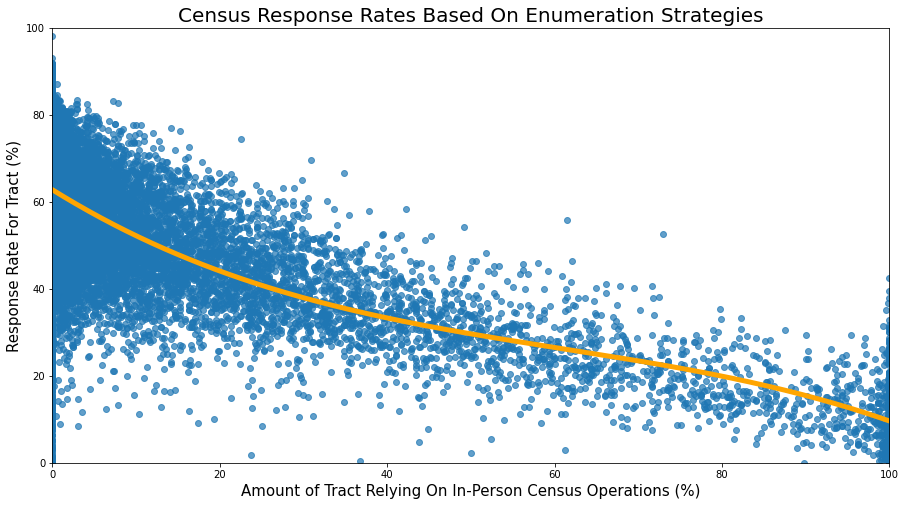

In [2]:
# make scatterplot of data and add logistic regression curve with arcsin-sqrt & intercept transformations
plt.figure(figsize=(15,8))
uniq = np.linspace(0,100,1001)
new_x = dmatrix("bs(train, df=df, degree=3, include_intercept=True)", {"train": data.inperson,\
        "df":np.max([m.ceil(1/(1-np.mean(data.inperson<1))),4])},return_type='dataframe')
model = sm.GLM(data.response, new_x)
results = model.fit()
plt.plot(data.inperson,results.predict(new_x),c='orange',linewidth=5)
plt.scatter(data.inperson,data.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
plt.title('Census Response Rates Based On Enumeration Strategies',size=20)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Amount of Tract Relying On In-Person Census Operations (%)',size=15)
plt.ylabel('Response Rate For Tract (%)',size=15)
plt.show()

Next, we will compare the response rates for two types of tracts:
* Those that do not rely on in-person census operations for initial contact at all
* Those that are entirely dependent on in-person census operations for initial contact

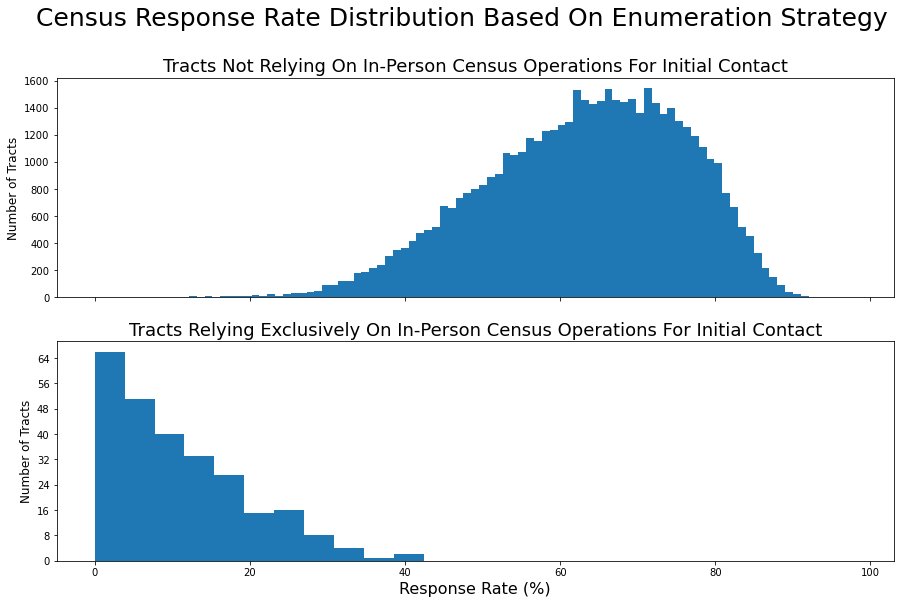

In [3]:
# make histograms of data
all_mail = data[data.inperson == 0]
all_inperson = data[data.mail == 0]
fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
plt.xlabel('Response Rate (%)',size=16)
plt.subplots_adjust(top=0.87)
plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy',size=25)
mai = ax[0]
inp = ax[1]
mai.yaxis.set_major_locator(MaxNLocator(integer=True))
inp.yaxis.set_major_locator(MaxNLocator(integer=True))
mai.set_ylabel('Number of Tracts',size=12)
inp.set_ylabel('Number of Tracts',size=12)
mai.hist(all_mail.response,bins='auto')
inp.hist(all_inperson.response,bins='auto')
mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)
plt.show()

As we compare these two types of areas, we can very clearly see how massive the response rate disparities between them are.

Surely, these will be assuaged to *some* degree once in-person operations ramp up again - but there is no telling how much (or how little) this gap will thin.

# State Case Studies

We will now conduct this same analysis for each of the fifty states, plus the District of Columbia.

Some of these states rely heavily on in-person enumeration (and thus will provide robust data), while some barely depend on it. The former category of state is more interesting to us, but we will show all of the states in alphabetical order for the sake of being thorough.

For each state, we will show these same graphs, and provide a list of any tracts in the state that rely entirely on in-person enumeration. I recommend [CUNY's Hard to Count map](https://www.censushardtocountmaps2020.us/) for visualizing and analyzing individual tracts.

Keep in mind - **we can easily do this analysis for a smaller region within a state or a group of states almost instantly** - email me any time at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) if you'd like to see these results for your region, too.

[*NewsCounts*](http://newscounts.org) provides countless data & research resources that make telling these stories easy - just drop us a line and we'll be happy to help.

**Note: be sure not to miss our [findings and additional information](#Conclusion) at the end of this guide.**


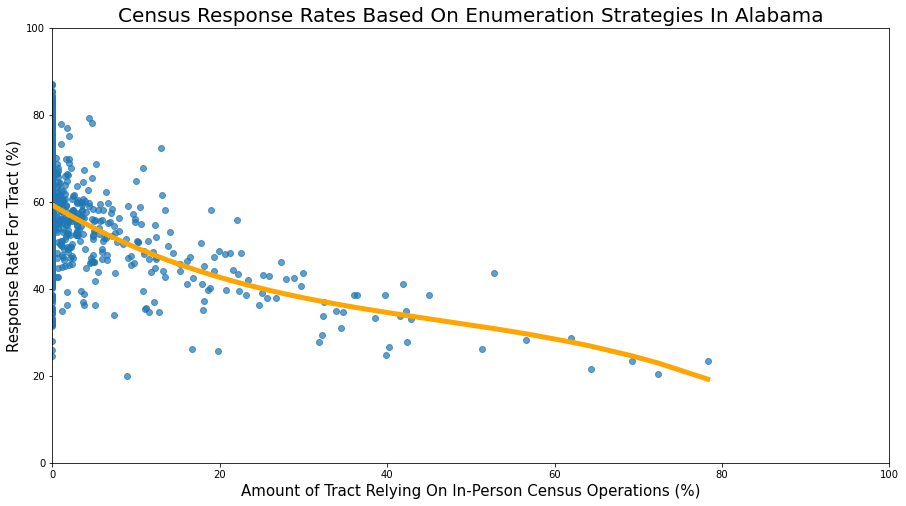

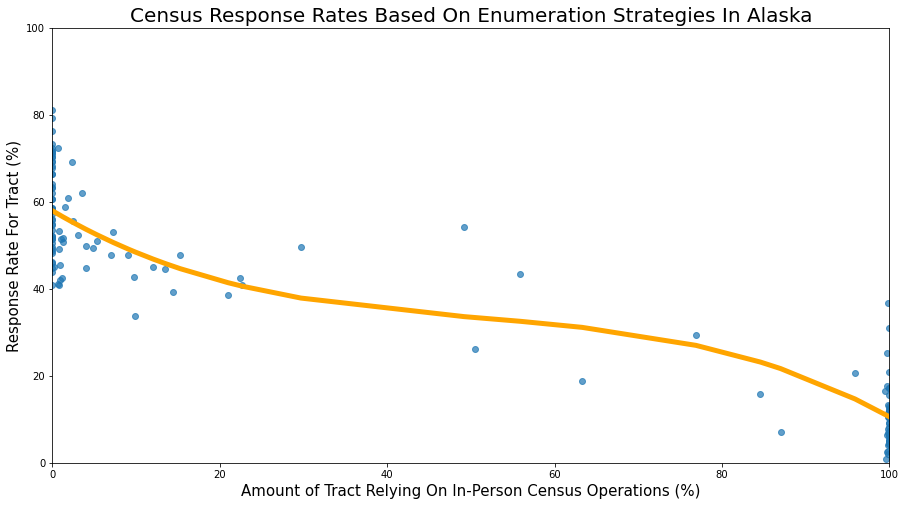

02013000100
02016000200
02020002900
02050000200
02070000200
02122000300
02122001200
02122001300
02170000501
02170000502
02170001300
02180000200
02185000100
02188000200
02195000200
02198000100
02198000200
02198940100
02220000100
02240000400
02275000300
02282000100


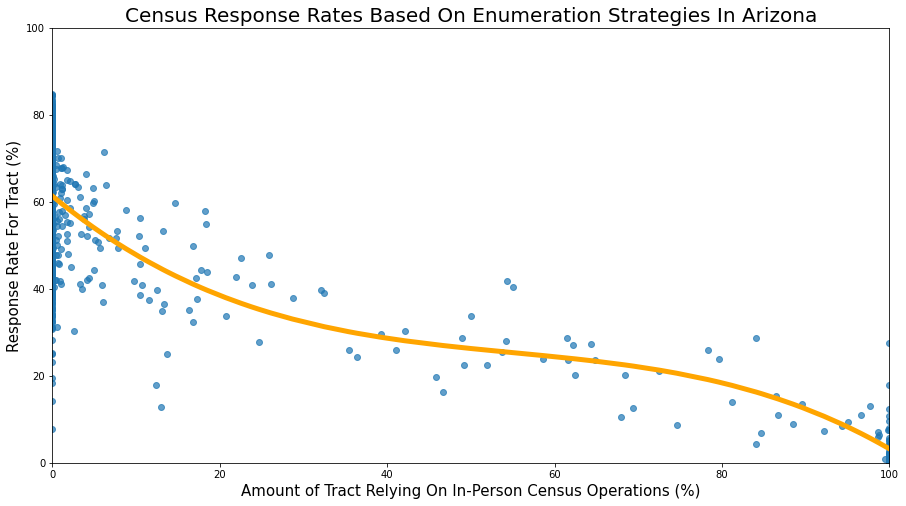

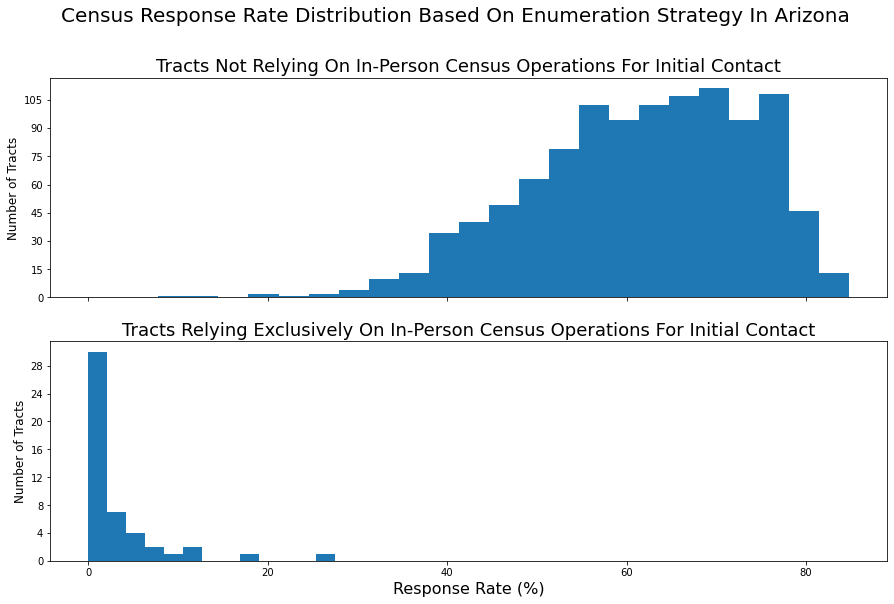

04001942600
04001942700
04001944000
04001944100
04001944201
04001944202
04001944901
04001944902
04001945001
04001945002
04001945100
04005942201
04005942202
04005944900
04005945000
04005945100
04005945200
04007940200
04007940400
04009940500
04012940200
04012940300
04013940700
04013941000
04013941100
04015940400
04017940008
04017940010
04017940011
04017940012
04017940013
04017940014
04017940015
04017940100
04017940301
04017940302
04017942300
04017942400
04017942500
04017963700
04017964201
04019940800
04019940900
04021941200
04025001300
04025002100
04027011403
04027011405


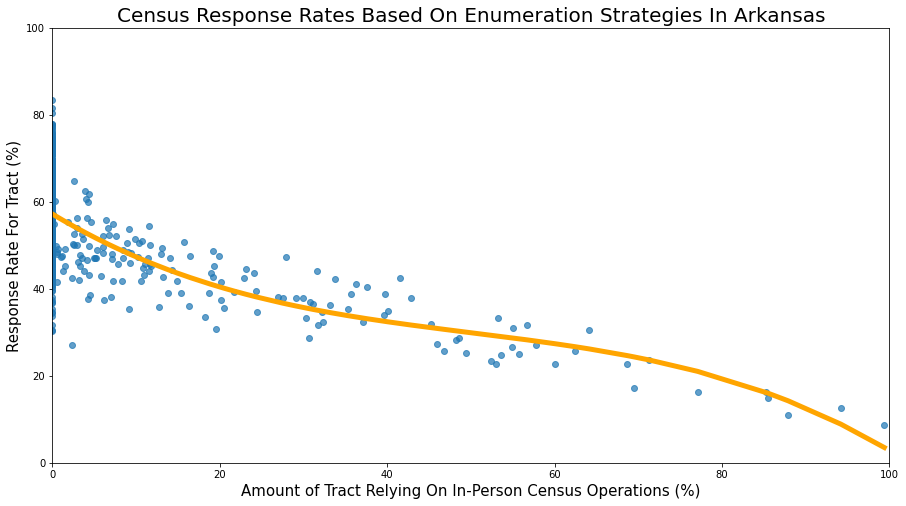

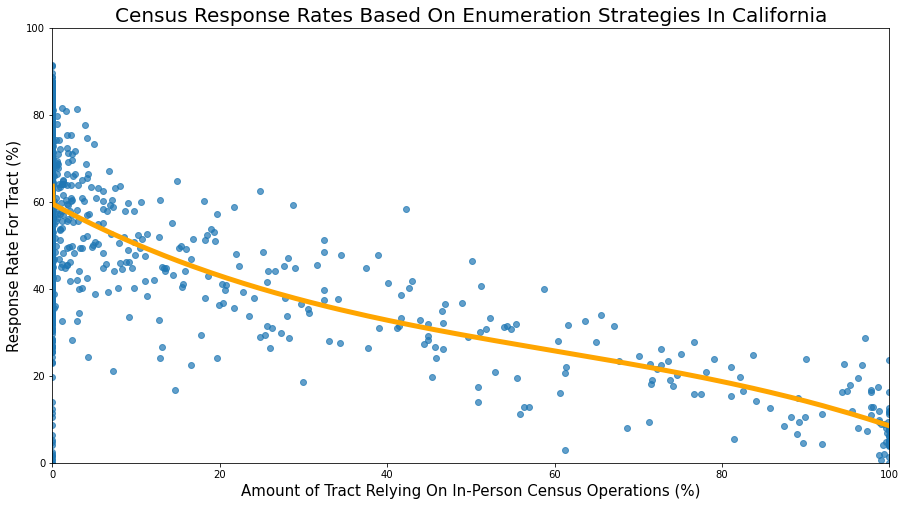

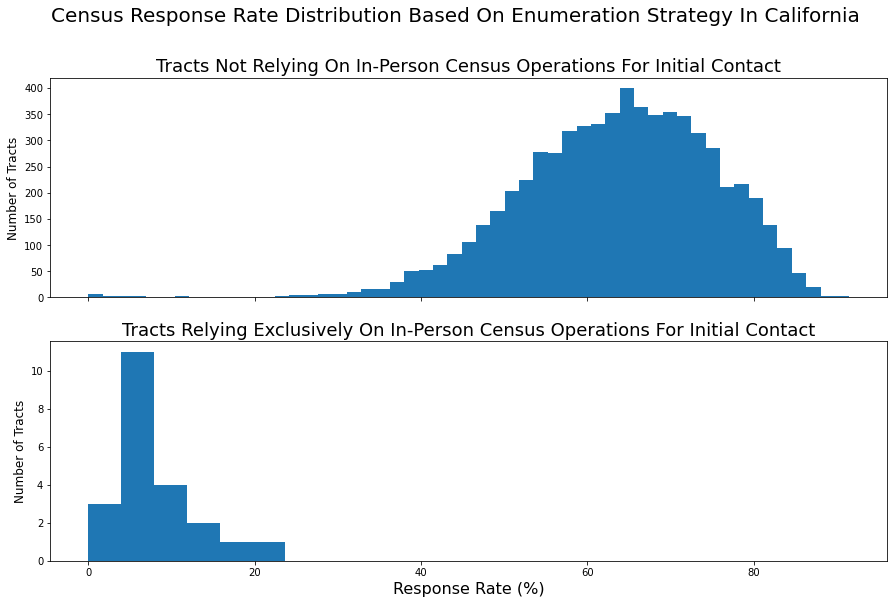

06007001800
06007001900
06007002000
06023940000
06037599000
06037599100
06041113000
06041122000
06059099506
06061020105
06061020106
06061020107
06061022100
06071009201
06071010803
06071010804
06071011203
06071011204
06071011205
06071011206
06071940100
06083980100


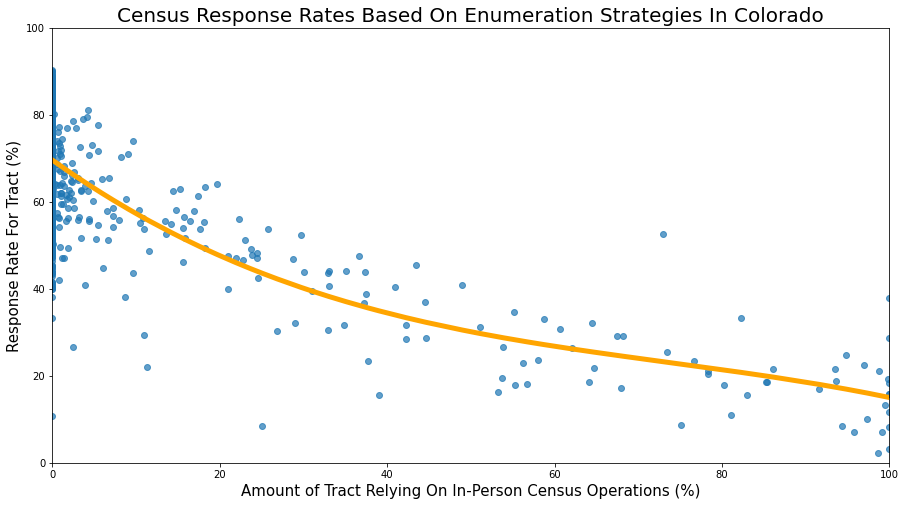

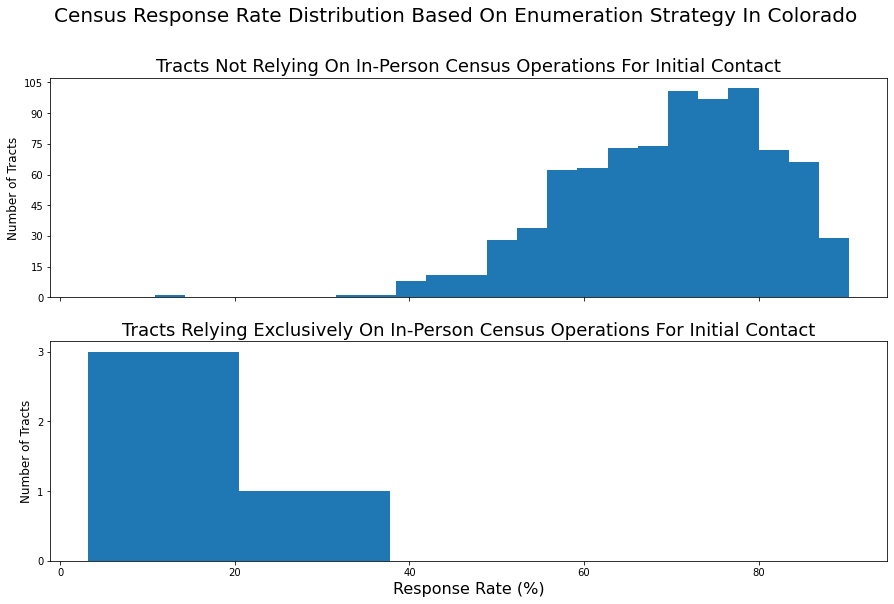

08007940400
08037000501
08037000502
08037000600
08067940300
08067940400
08107000200
08113968101


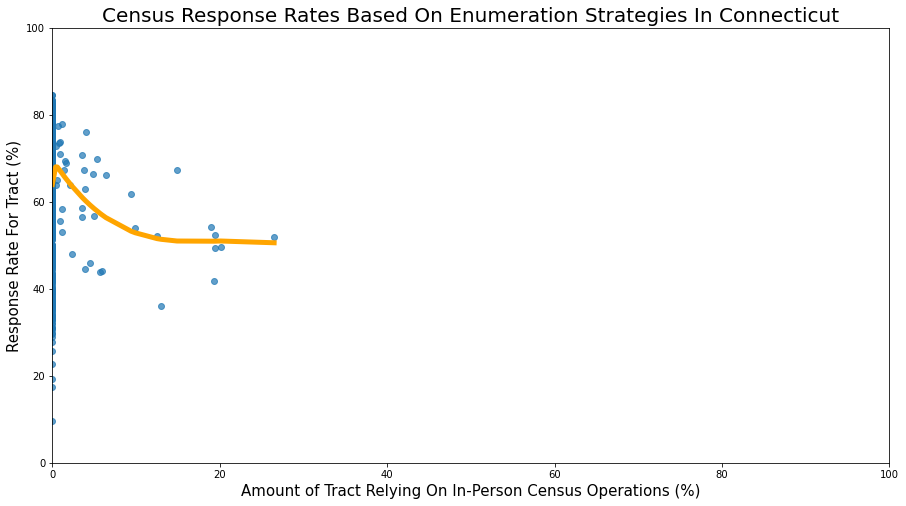

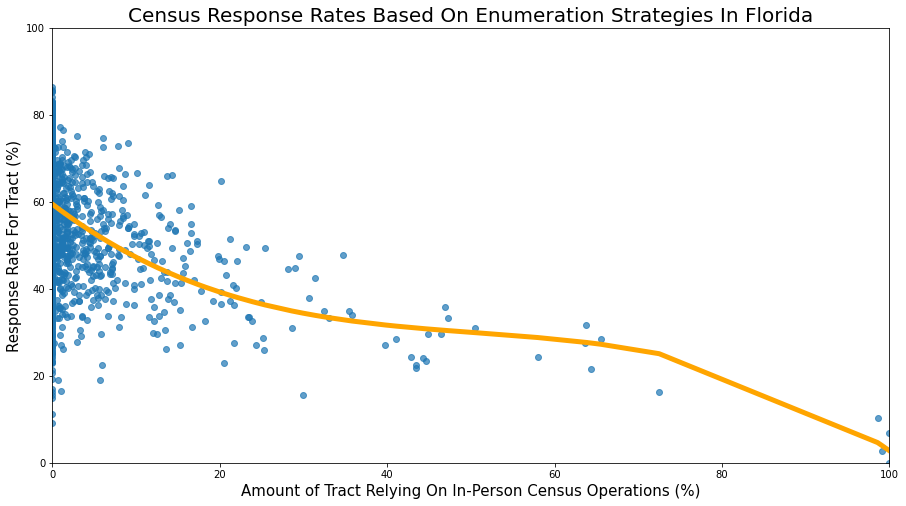

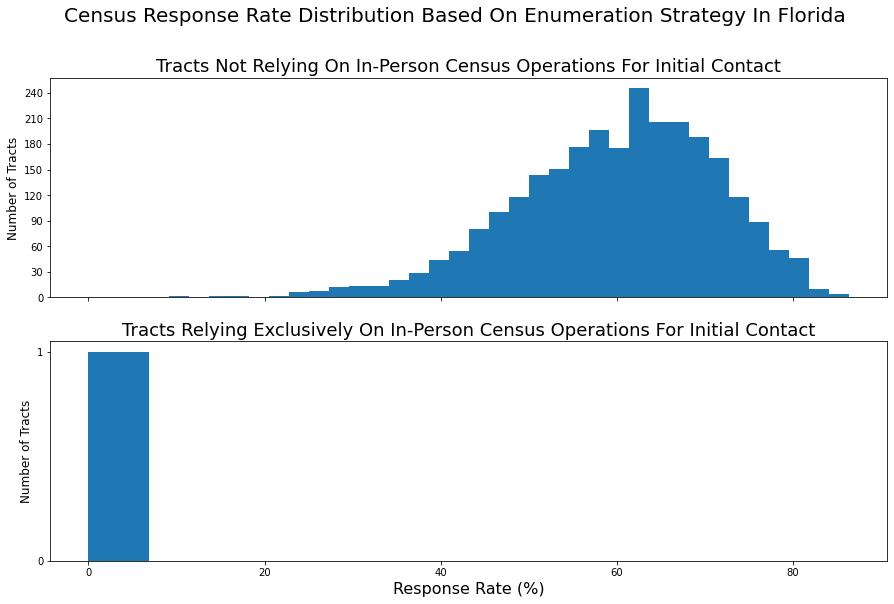

12005000600
12005000700


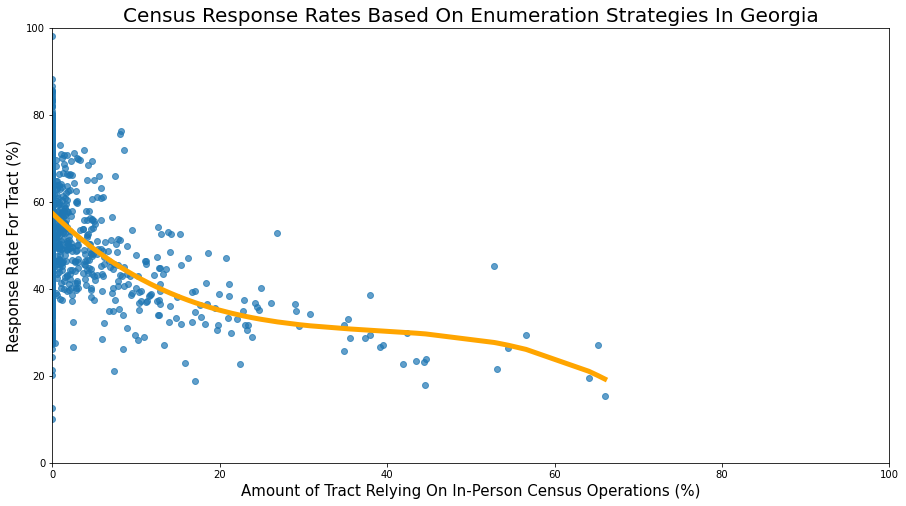

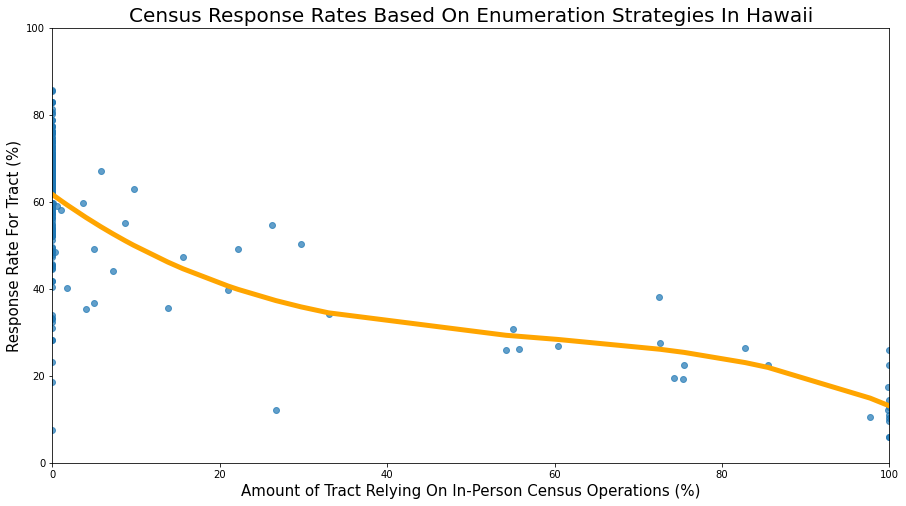

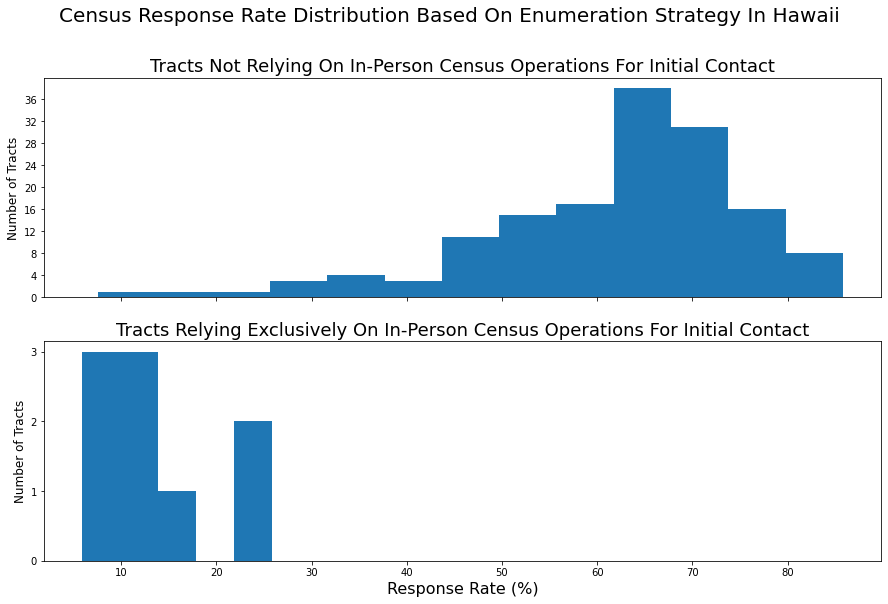

15001021003
15001021011
15001022102
15005031900
15007040104
15007040800
15007040900
15009031700
15009031801


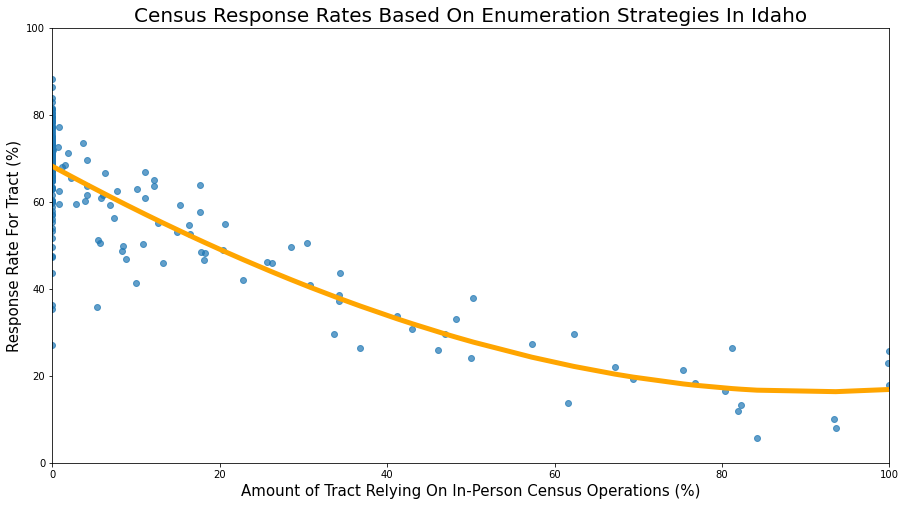

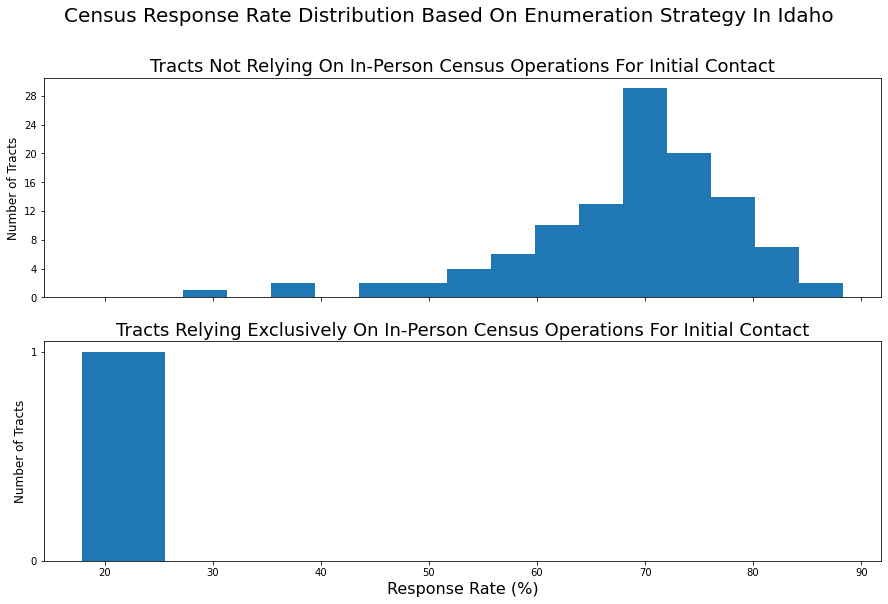

16005940000
16011940000


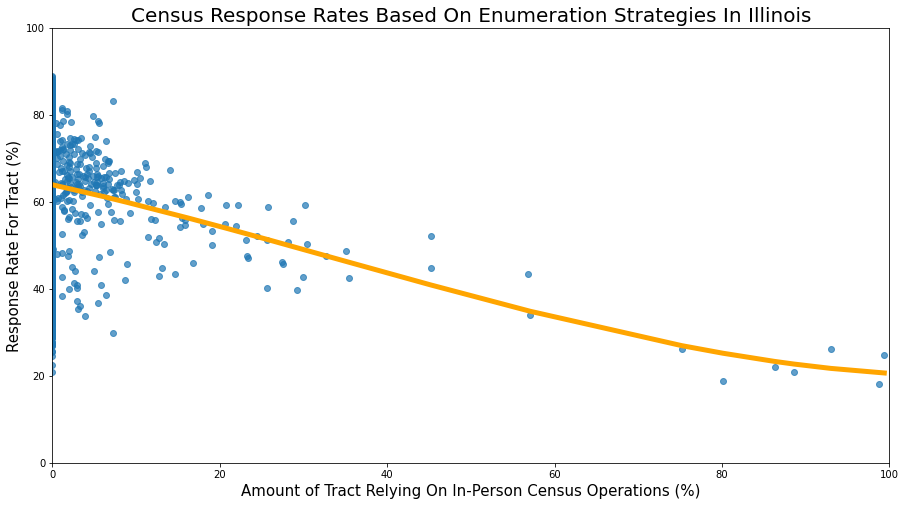

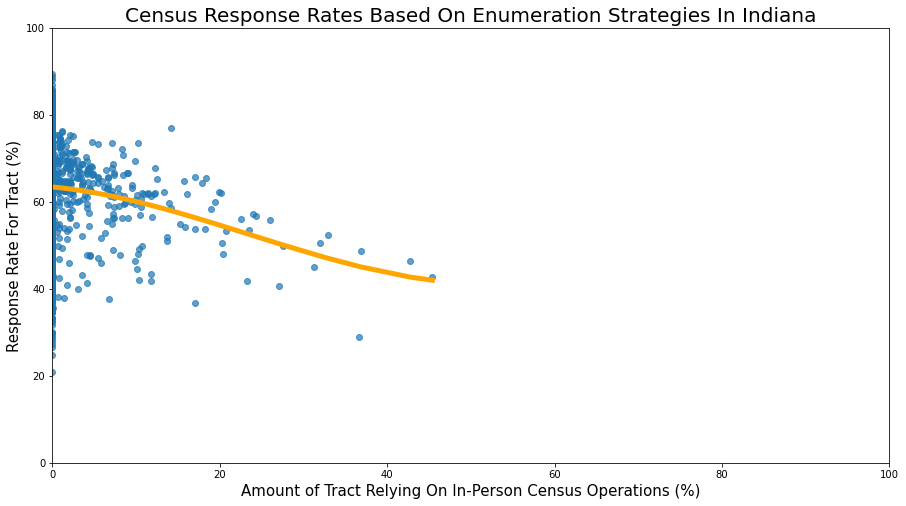

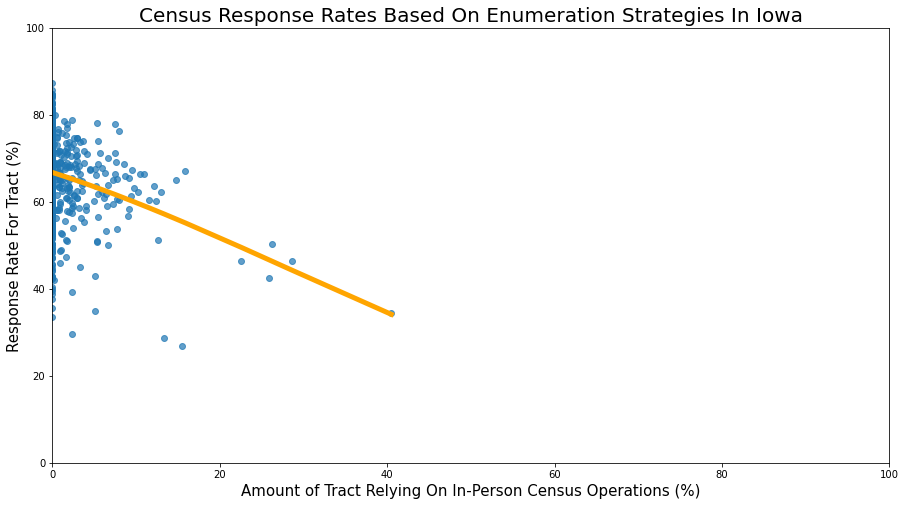

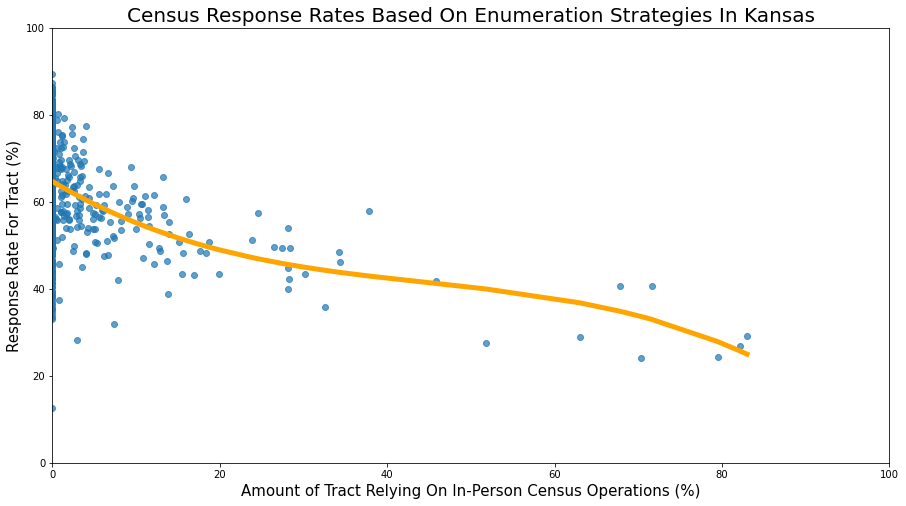

21095970600
21121930602
21131920200
21131920300
21189930100
21189930200


22071004800


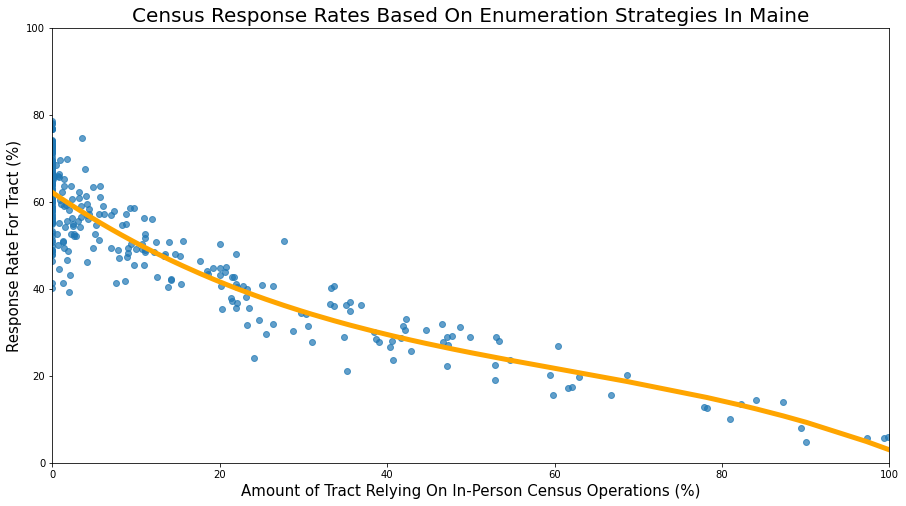

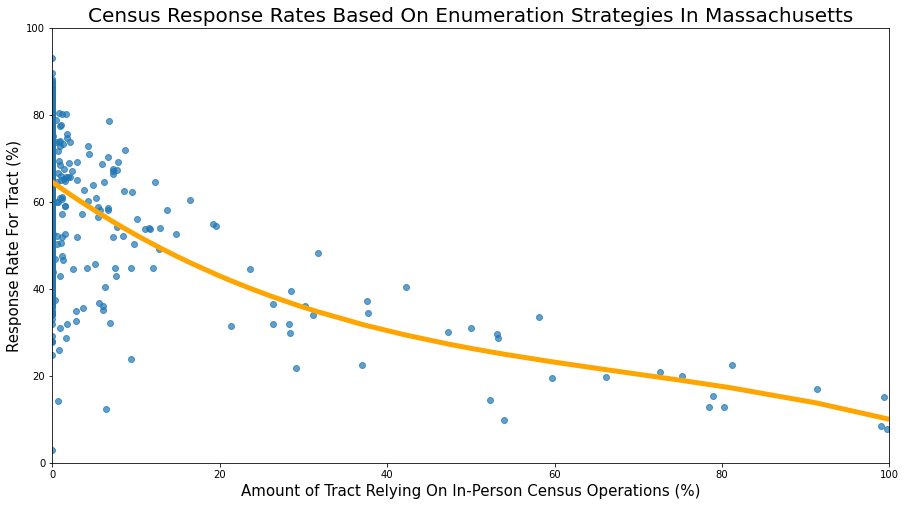

26099982100


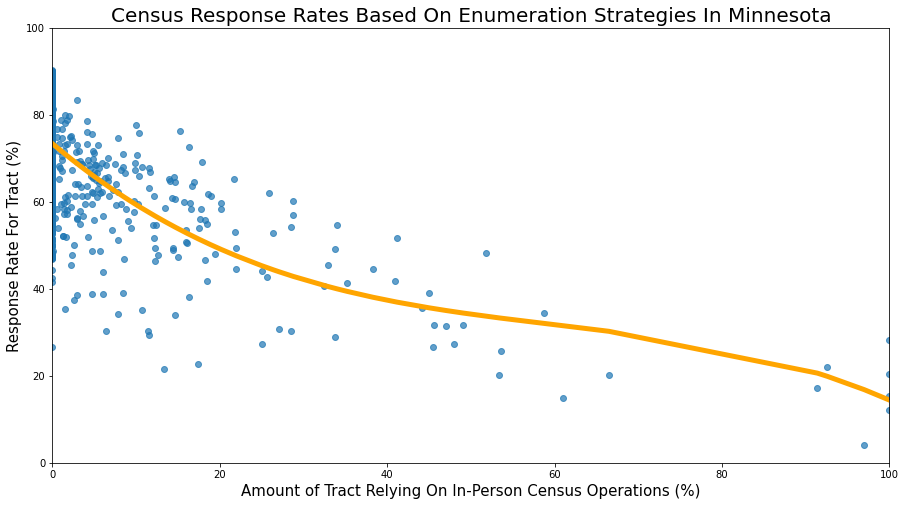

27021940002
27061940000
27087940100
27087940300


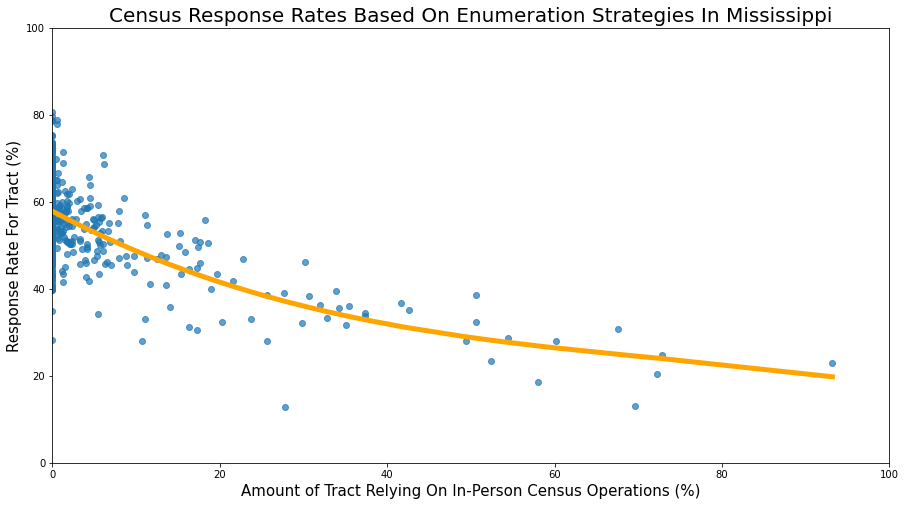

30003940600
30003940700
30005940100
30005940200
30035940200
30035940400
30035980000
30085940001
30085940002
30087940400


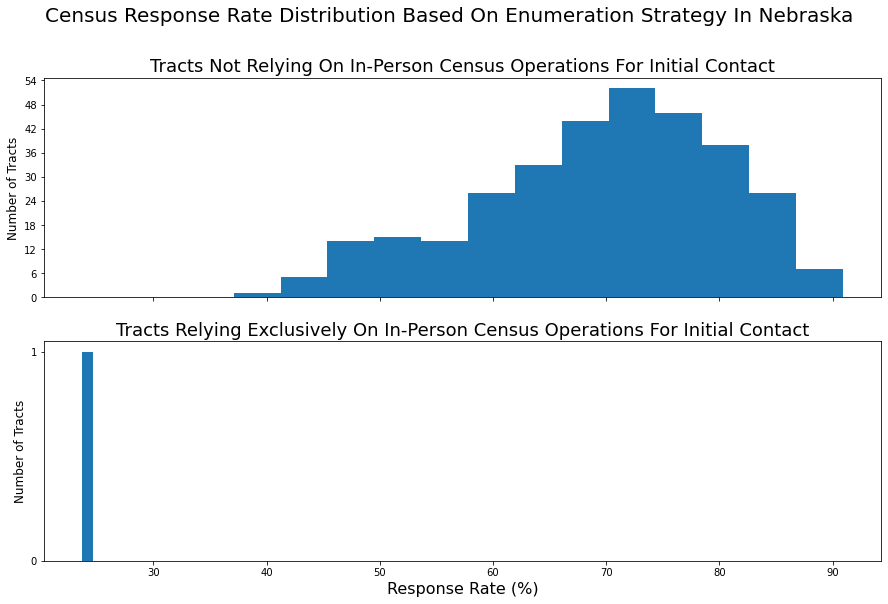

31173940100


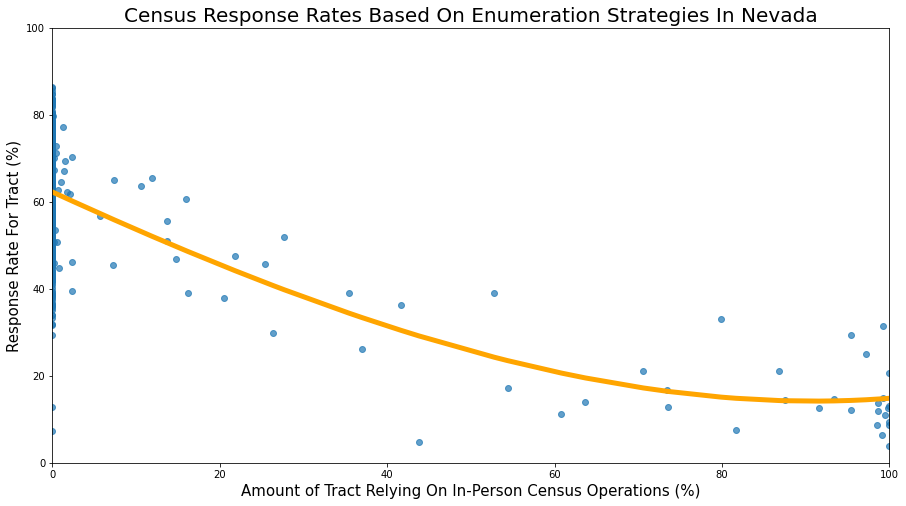

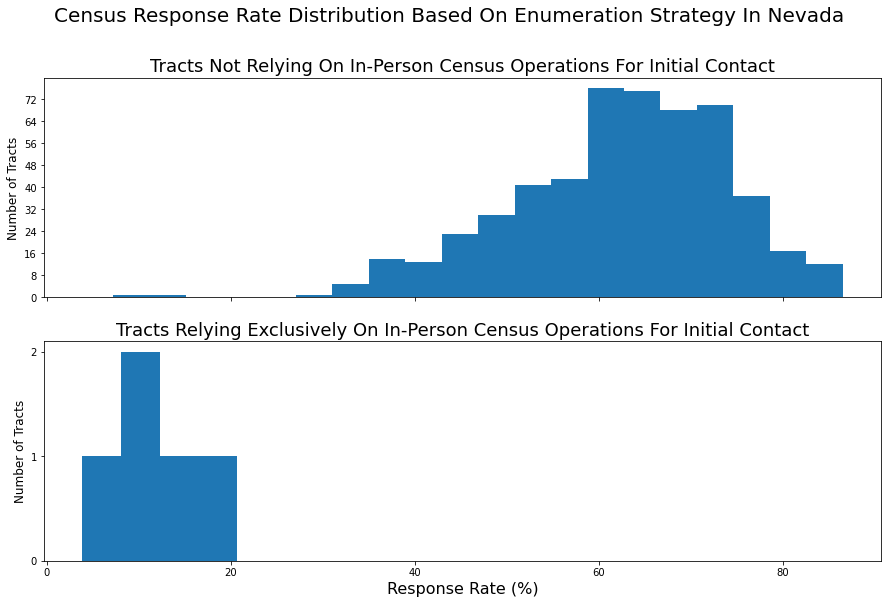

32003005612
32005001700
32005001800
32009950100
32031940200


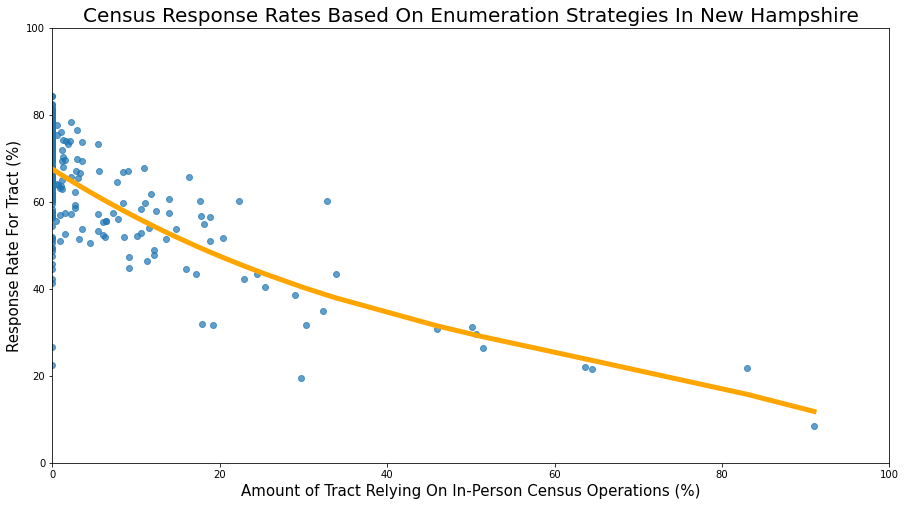

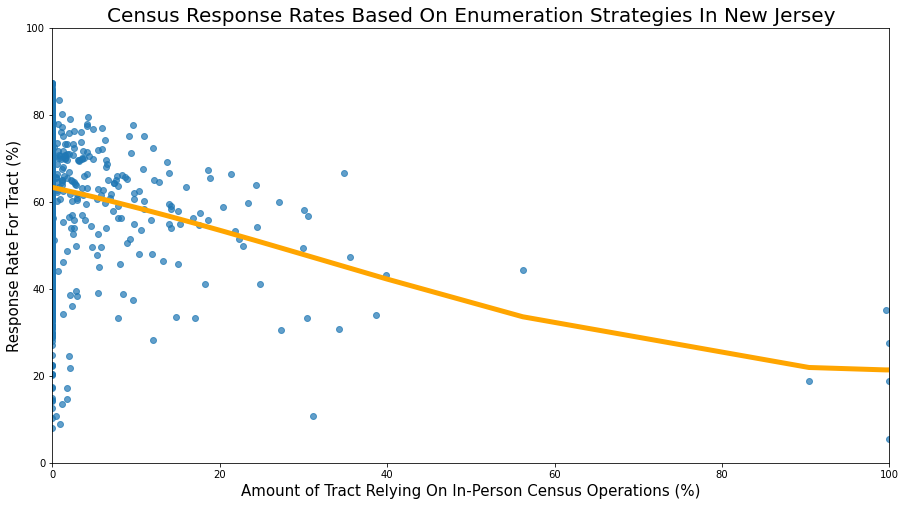

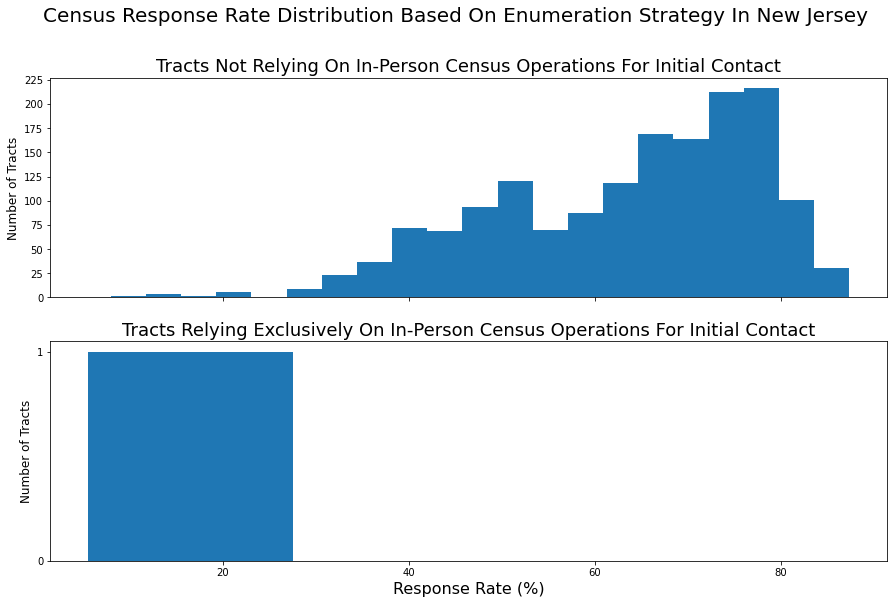

34005702101
34025809903
34029729000


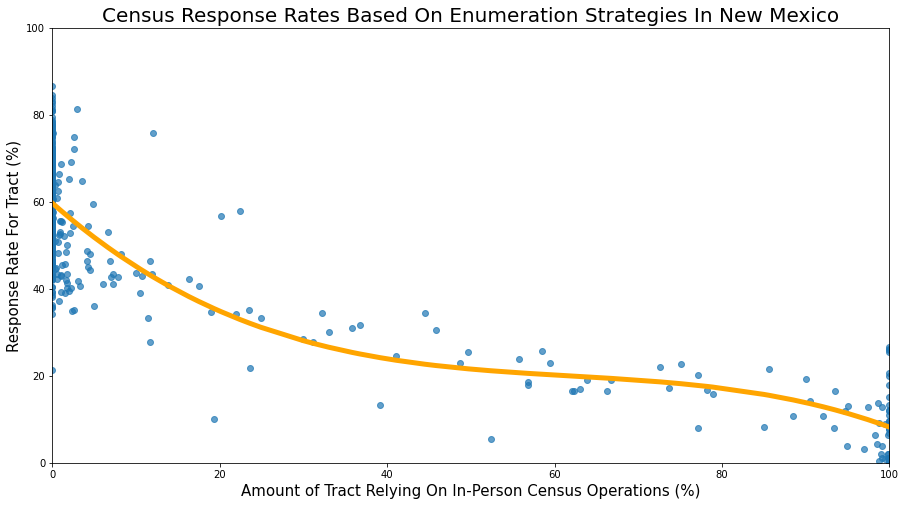

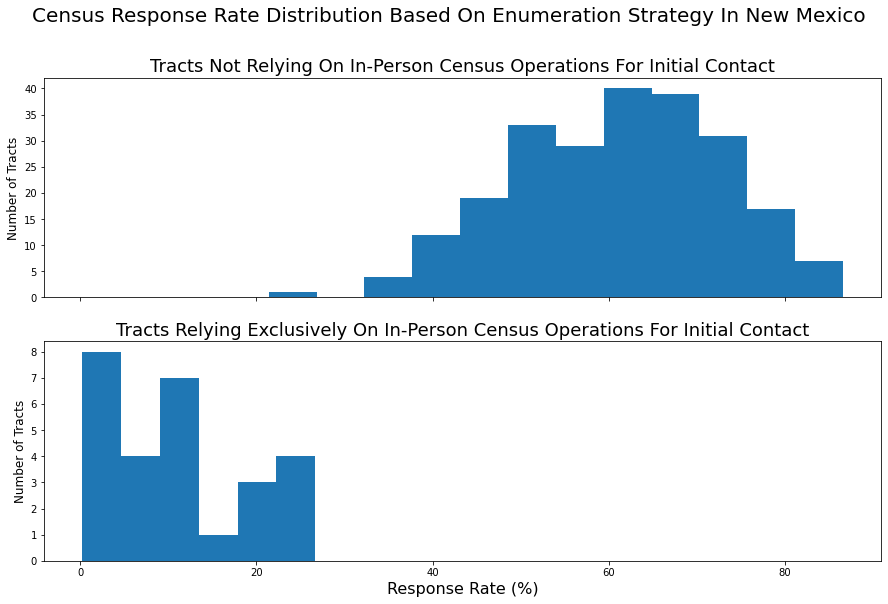

35001940700
35006941500
35006946100
35025000800
35031940500
35031943700
35031943800
35035940000
35039000100
35039940700
35039940800
35039944100
35043940500
35043940600
35043940700
35045942801
35045942802
35045942803
35045942900
35045943000
35045943100
35049940300
35049940500
35049940600
35049940900
35055940000
35061940300


36033940000
36067940000
36103180300


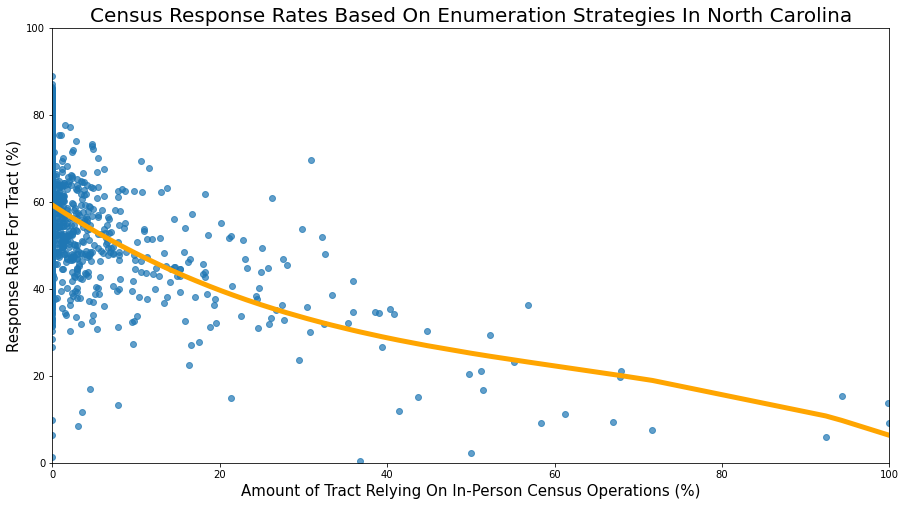

37133000800


38053940100
38061940300
38061940400
38079941800
38085940800
38085940900


40007951700
40025950100
40113940001
40113940003
40113940004
40113940005
40113940006
40113940007
40113940008
40113940009
40113940011


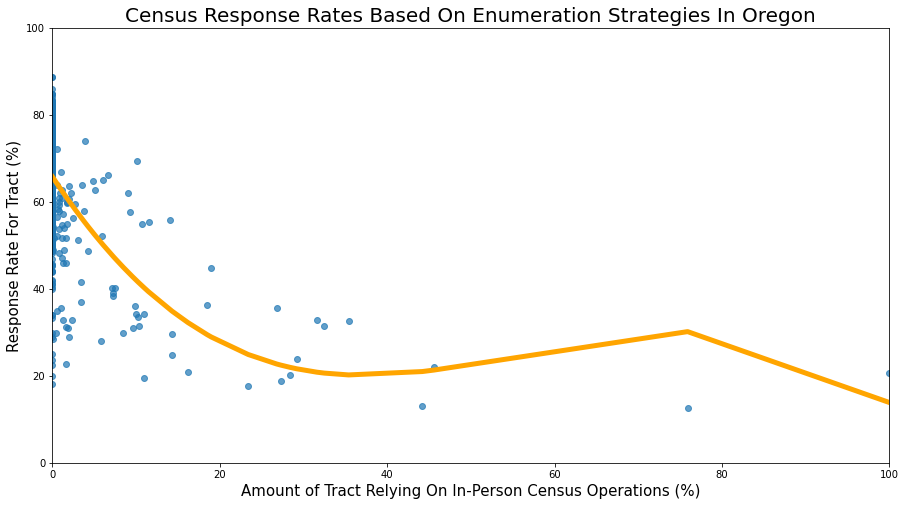

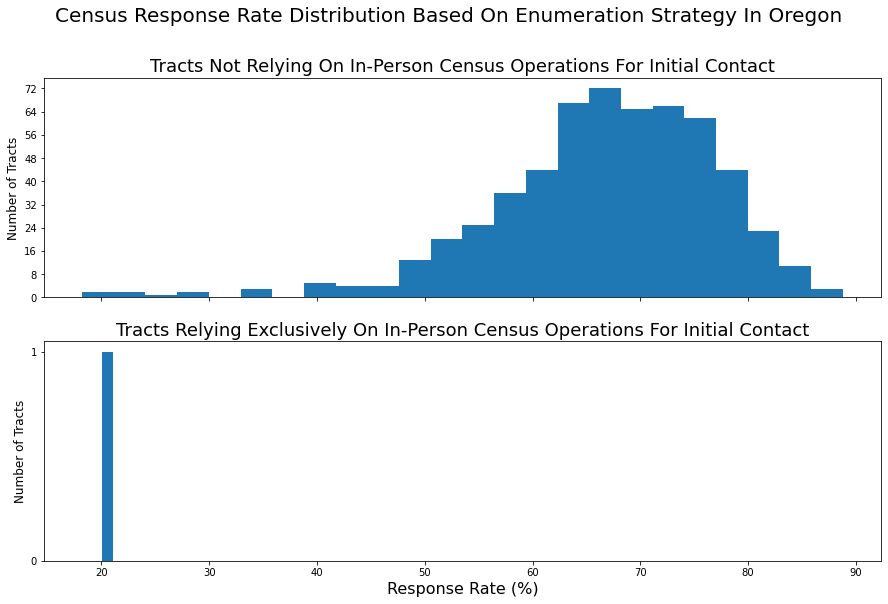

41031940000


42079216501


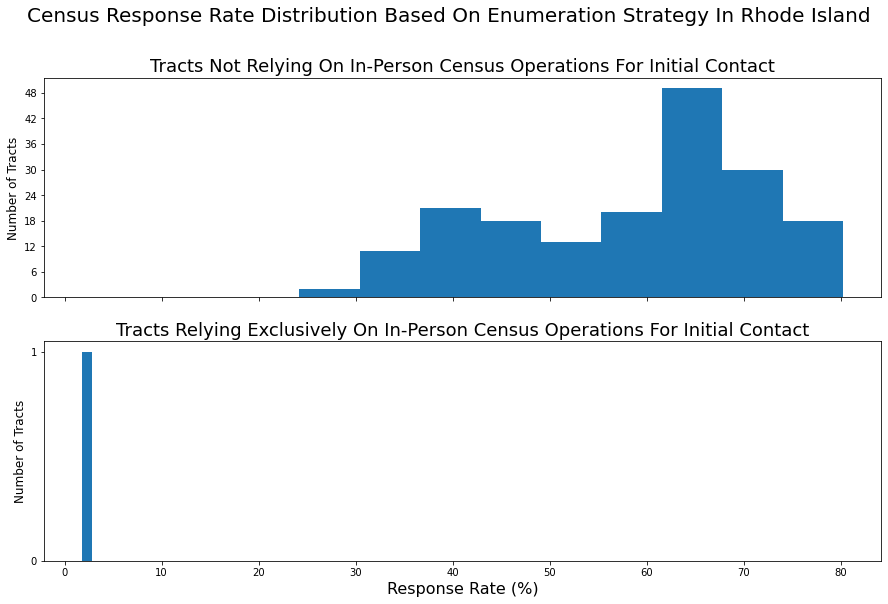

44009041500


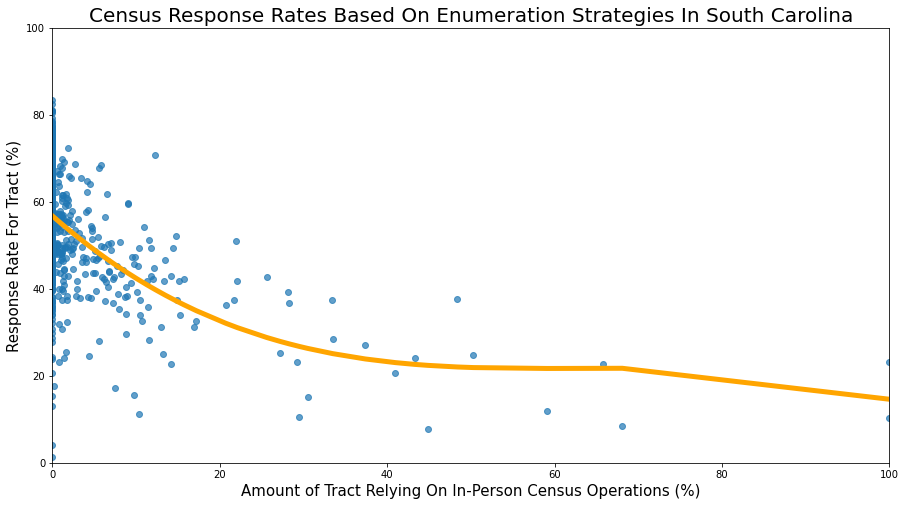

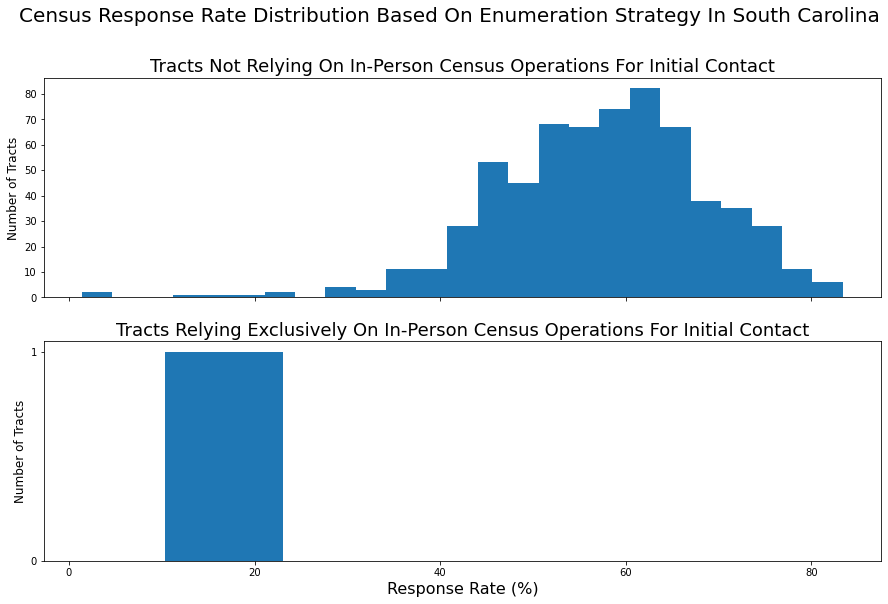

45019002004
45019003200


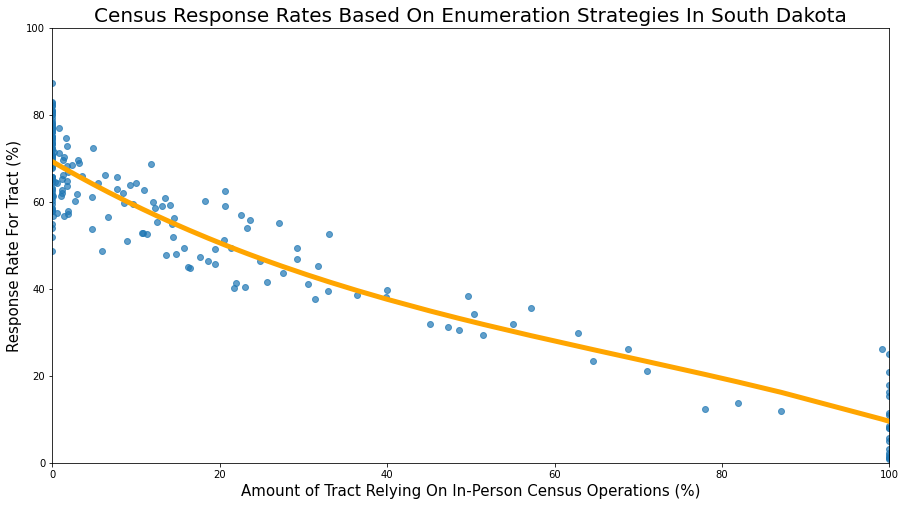

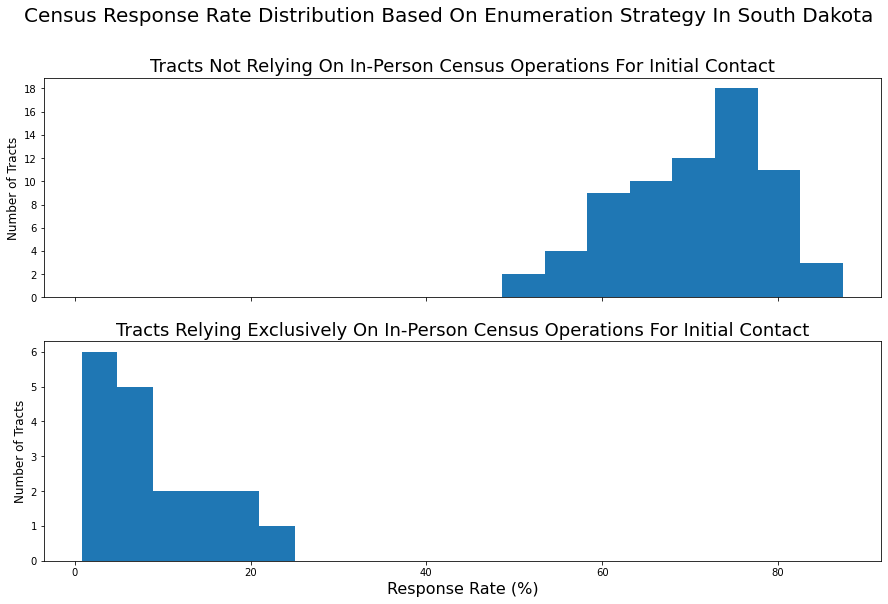

46007941000
46007941200
46023940200
46023940300
46031941000
46031941100
46041941500
46041941700
46071941200
46085940100
46102940500
46102940800
46102940900
46109940400
46109940800
46121940100
46121940200
46137941600


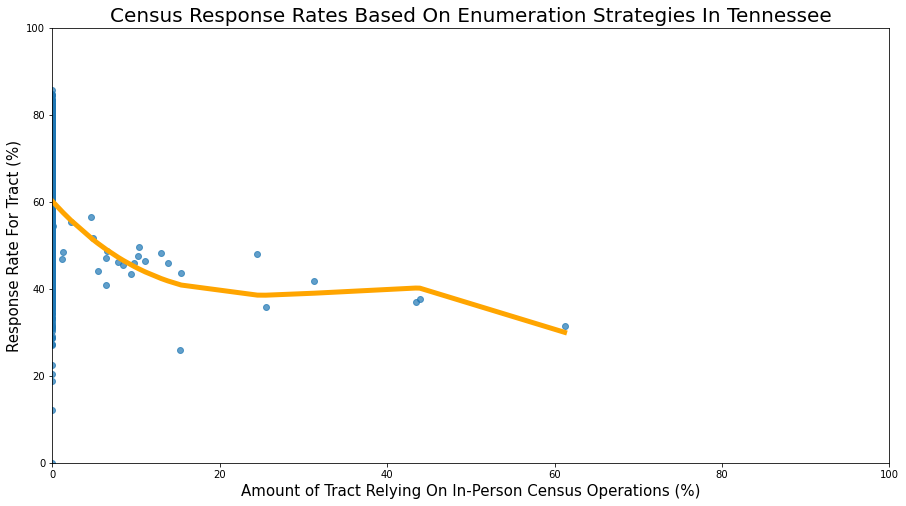

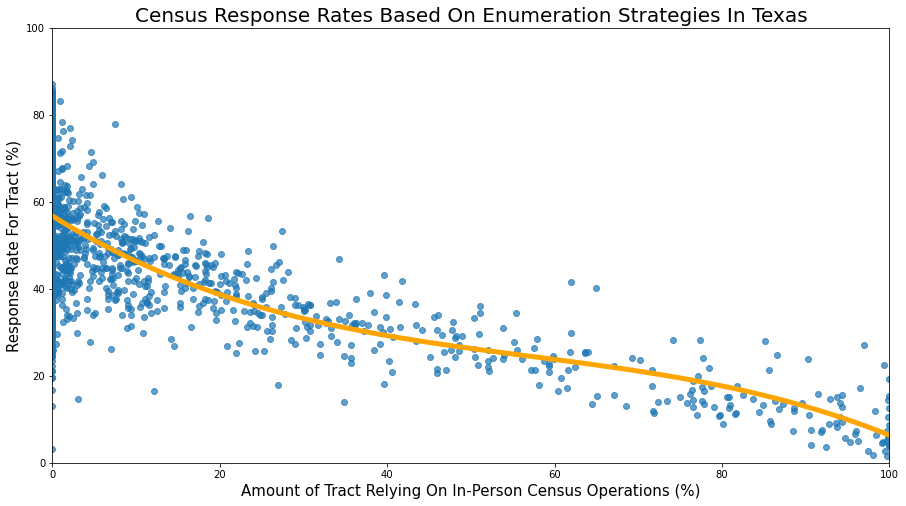

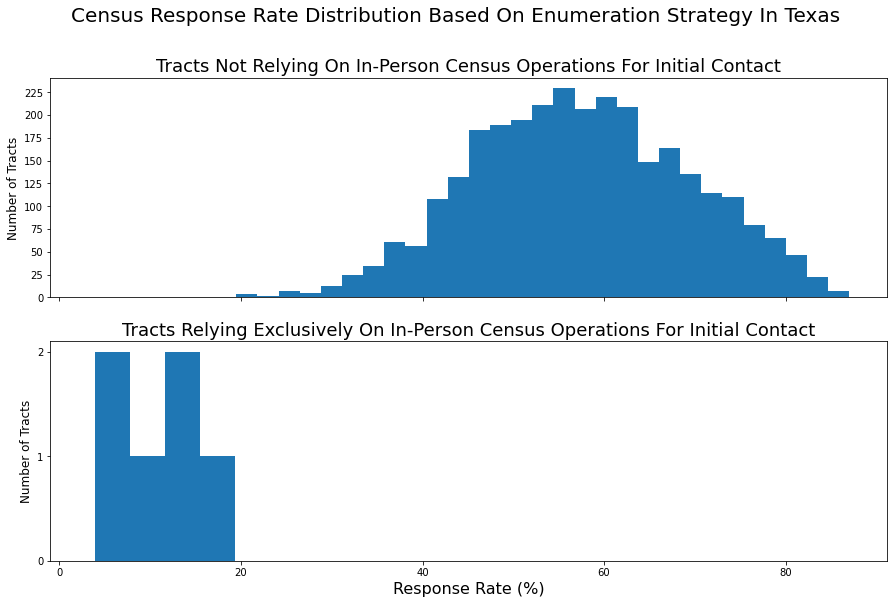

48141010505
48141010506
48215024403
48409010500
48507950100
48507950200


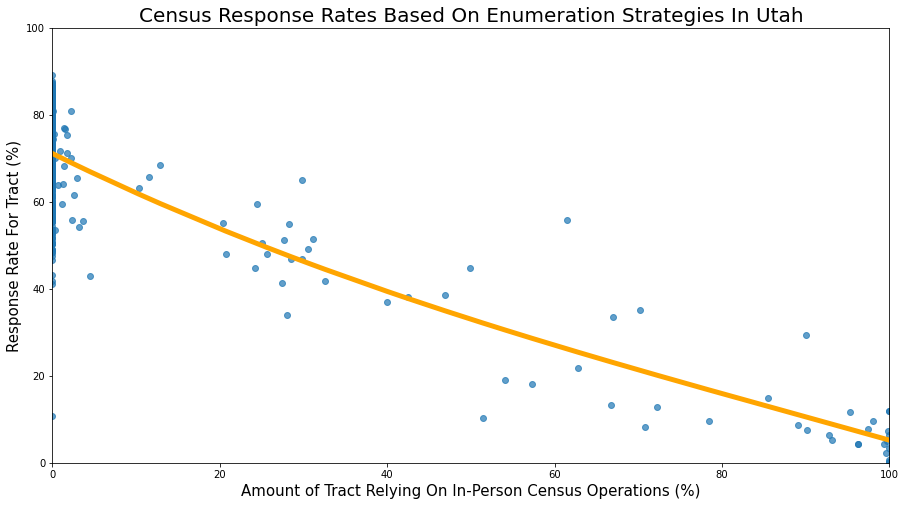

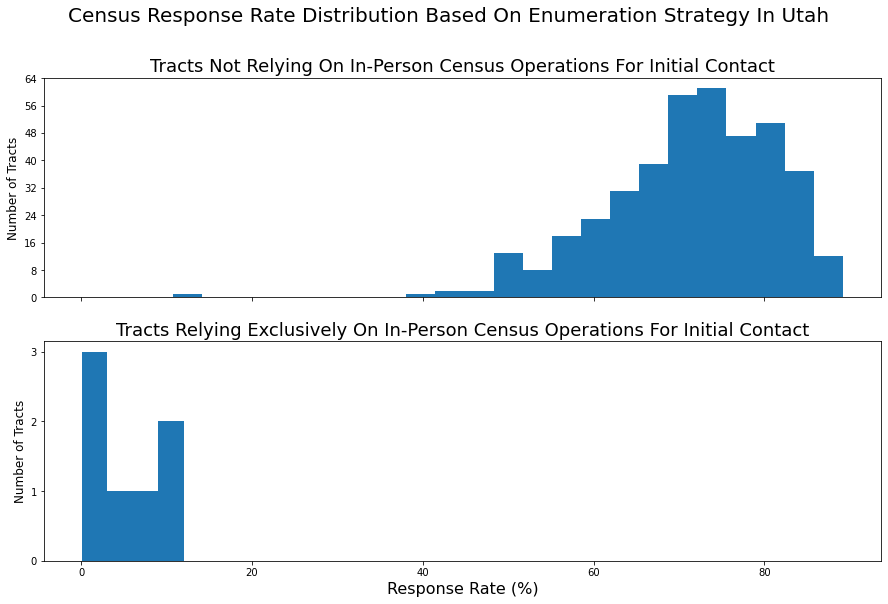

49013940300
49013940600
49015976300
49037942000
49037942100
49043964203
49047940201


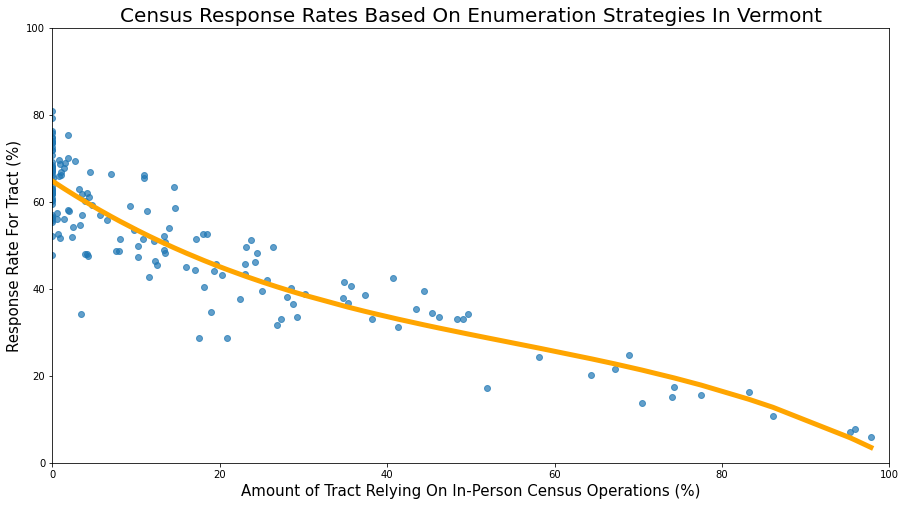

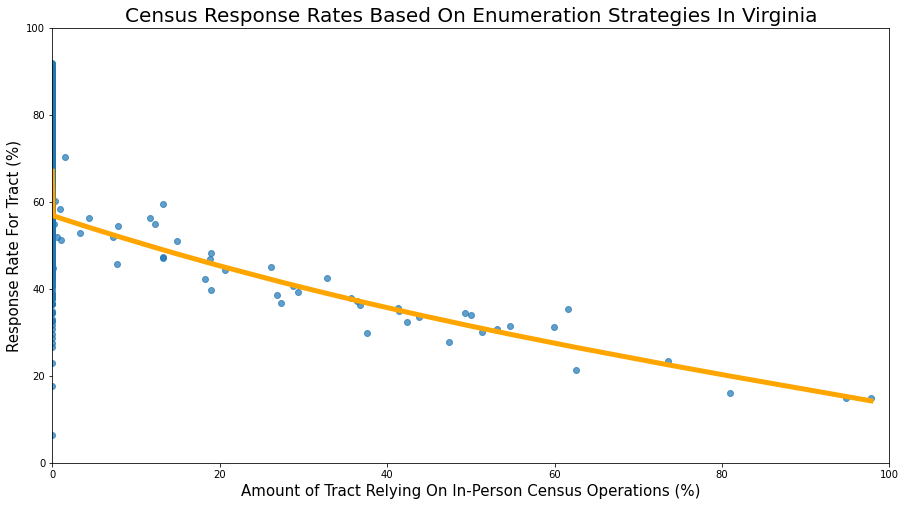

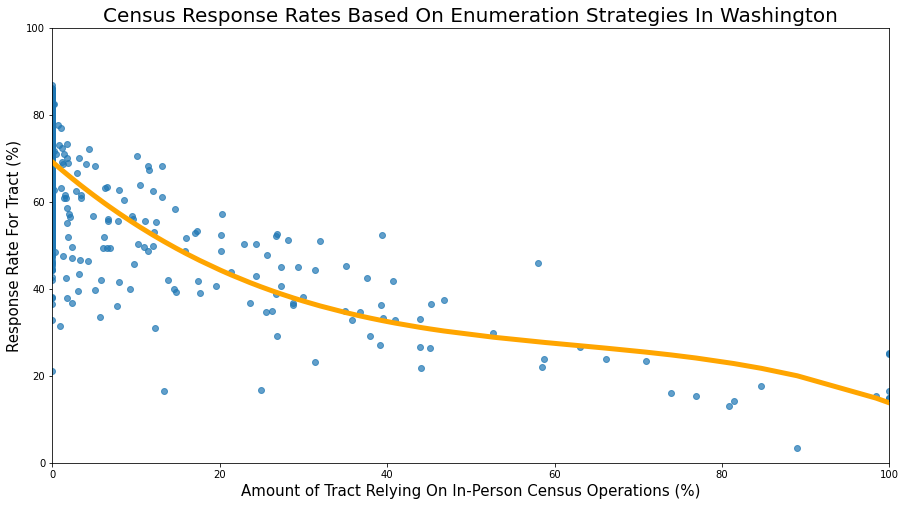

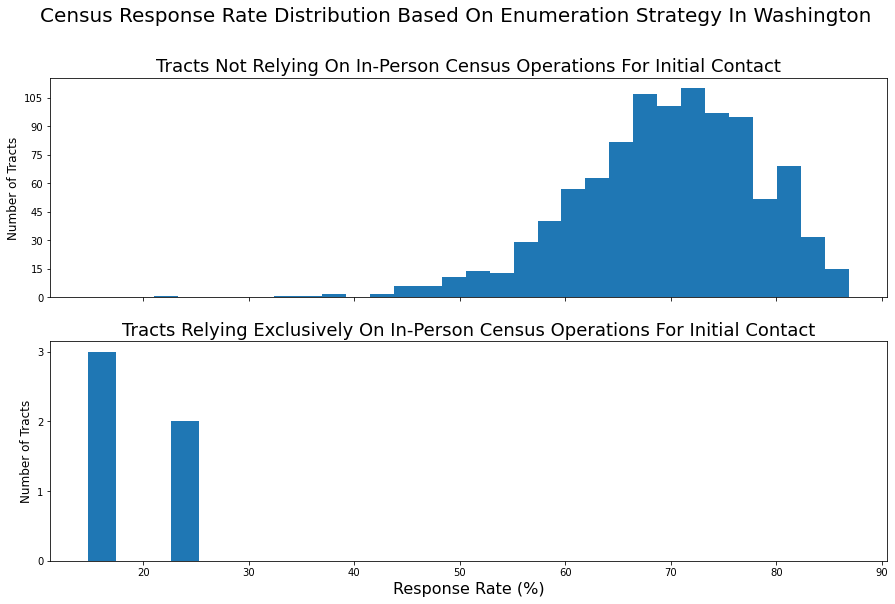

53019940000
53027940000
53047940100
53047940200
53065941000


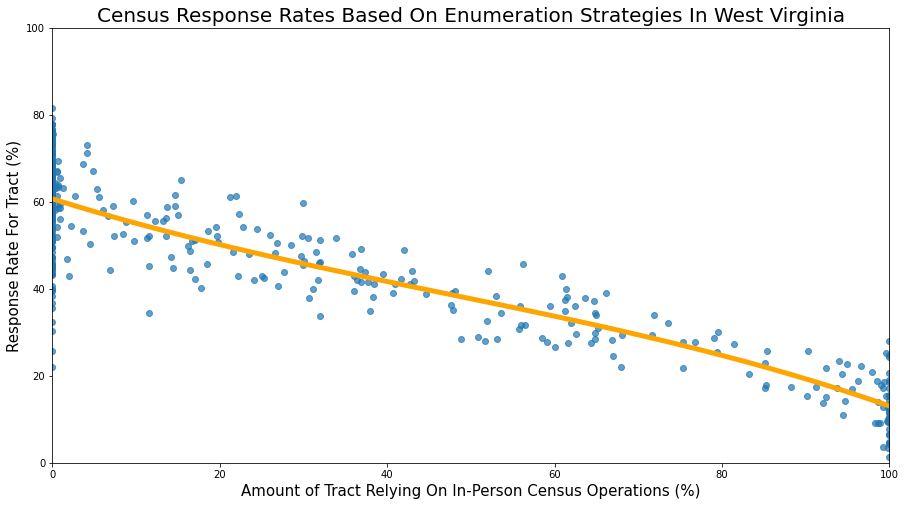

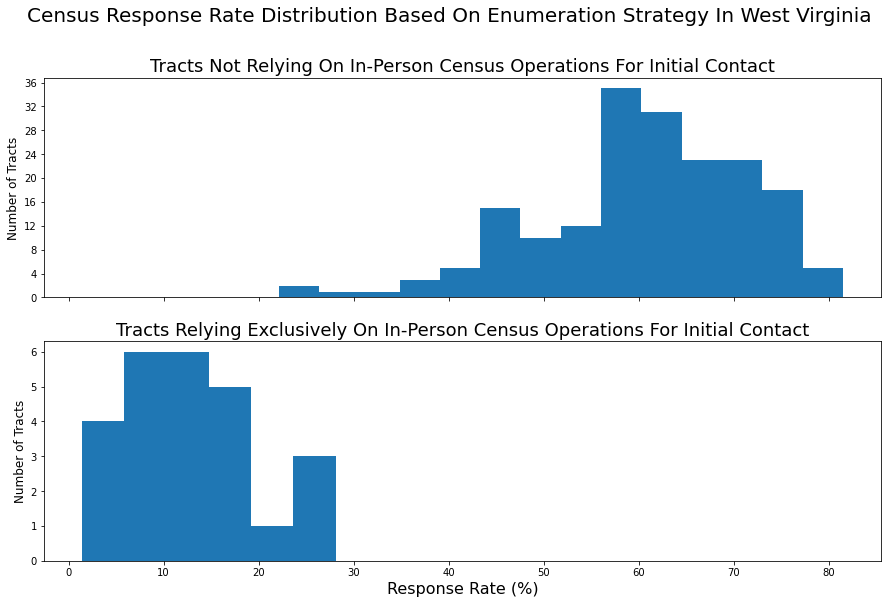

54019020500
54045956102
54045956500
54045956700
54045956800
54047953600
54047953800
54047953900
54047954200
54047954504
54057010100
54059957100
54059957200
54059957300
54059957700
54075960102
54081001002
54083966500
54089000600
54089000700
54089000800
54099020800
54109002800
54109002902
54109003100


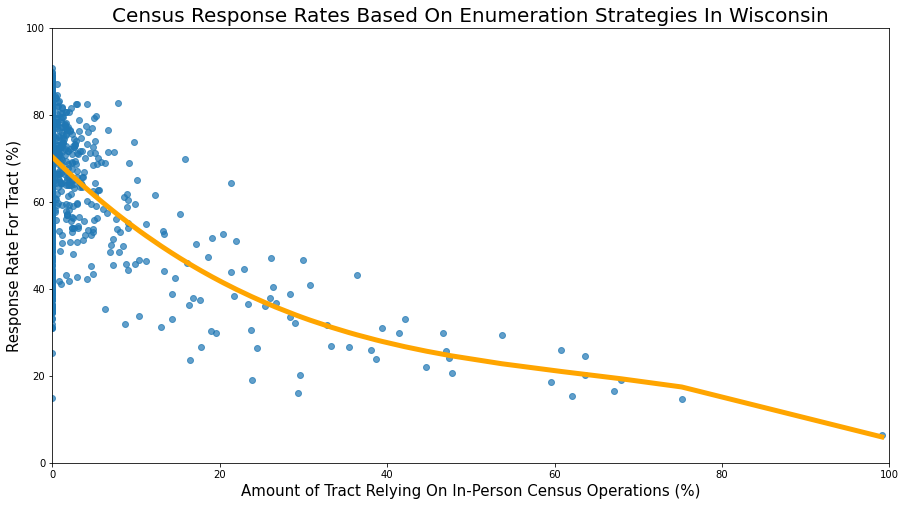

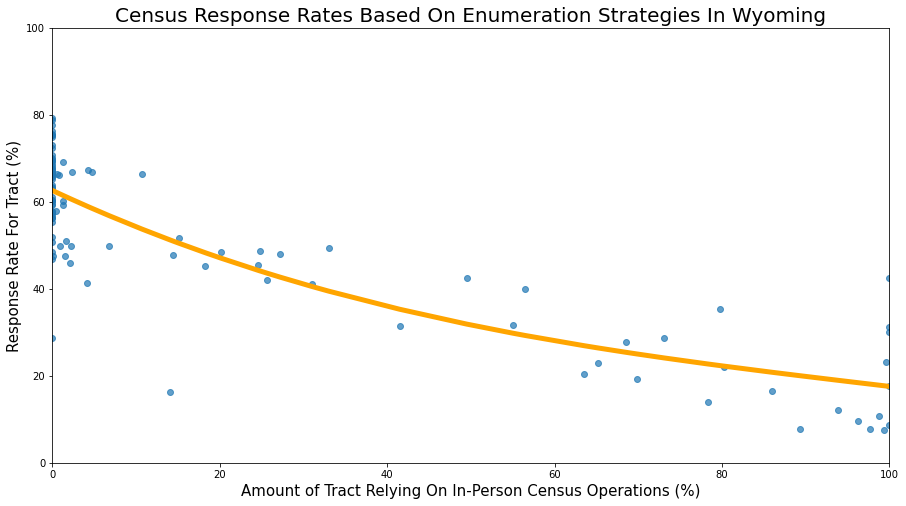

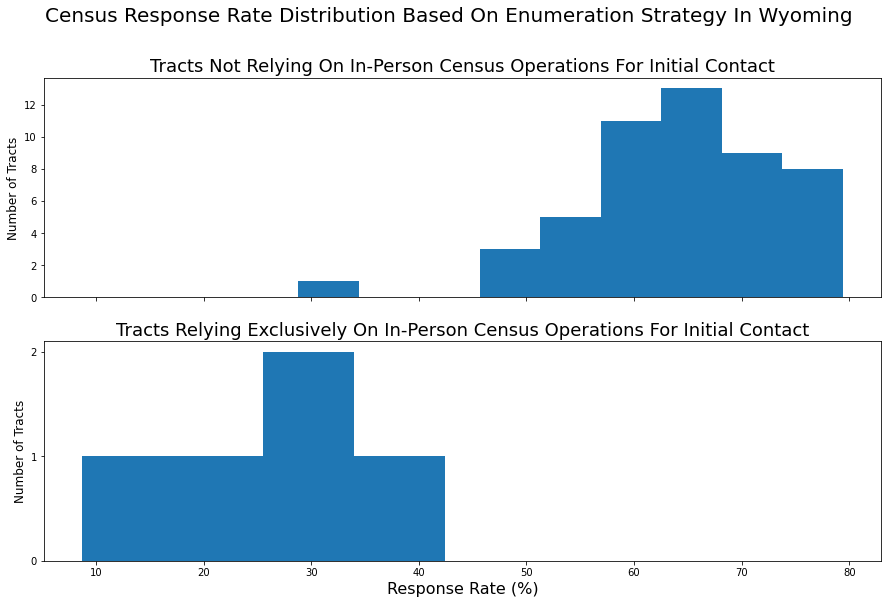

56013940100
56013940201
56013940202
56013940400
56013940500


In [4]:
# get names of areas to aid lookup in helper function below
names = pd.read_excel('https://www2.census.gov/programs-surveys/popest/geographies/2017/state-geocodes-v2017.xlsx',\
          skiprows=range(5),index_col=2).iloc[:,2]
names.columns=['name']

# add hyperlinks to each state
html = '<h2>Shortcut to state:</h2><p>'
links = sorted(names[names.index!=0])
for link in links:
    html += "<a href='#" + link + "'>" + link + "<br/></a>" 
html += "</p><h3><a href='#Conclusion'>Skip to Conclusion / Additional Information" + "</a></h3>"
display(HTML(html))

# helper function to plot individual areas
def show_area(fips):
    
    # convert to string
    area = str(fips)
    if len(area) == 1:
        area = area.zfill(2)
        
    # get name of area
    name = names[fips]
    
    # show name of area and add anchor
    display(HTML("<center><h1 id='" + name + "'>" + name +"</h1></center>"))
    
    # trim dataset to include only area in question and sort
    new = data[data.index.str.startswith(area)]
    new = new.sort_values('inperson')
    
    # if none of area relies on in-person enumeration, note and return
    if sum(new.inperson) == 0:
        display(HTML('<h4>' + name + ' does not rely on in-person enumeration</h4>'))
        return
    
    # generate separate datasets for areas with all in-person and no in-person enumeration  
    all_mail = new[new.inperson == 0]
    all_inperson = new[new.mail == 0]
    
    # generate list of tracts that rely completely on in-person enumeration
    tracts = sorted(all_inperson.index)
    
    # make scatterplot of data, fitting logistic regression curve with arcsin-sqrt and intercept transformations
    plt.figure(figsize=(15,8))
    uniq = np.linspace(0,100,1001)
    new_x = dmatrix("bs(train, df=df, degree=3, include_intercept=True)", {"train": new.inperson,\
            "df":np.max([m.ceil(1/(1-np.mean(new.inperson<1))),4])},return_type='dataframe')
    model = sm.GLM(new.response, new_x)
    results = model.fit()
    plt.plot(new.inperson,results.predict(new_x),c='orange',linewidth=5)
    plt.scatter(new.inperson,new.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
    plt.title('Census Response Rates Based On Enumeration Strategies In ' + name,size=20)
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('Amount of Tract Relying On In-Person Census Operations (%)',size=15)
    plt.ylabel('Response Rate For Tract (%)',size=15)
    plt.show()
    
    if len(tracts) != 0:
        # make histogram of data
        fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
        plt.xlabel('Response Rate (%)',size=16)
        plt.subplots_adjust(top=0.87)
        plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy In ' + name,size=20)
        mai = ax[0]
        inp = ax[1]
        mai.yaxis.set_major_locator(MaxNLocator(integer=True))
        inp.yaxis.set_major_locator(MaxNLocator(integer=True))
        mai.set_ylabel('Number of Tracts',size=12)
        inp.set_ylabel('Number of Tracts',size=12)
        mai.hist(all_mail.response,bins='auto')
        inp.hist(all_inperson.response,bins='auto')
        mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
        inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)
        plt.show()

    # print total number of tracts examined
    display(HTML('<h4>Total number of tracts examined in ' + name + ': ' + str(new.shape[0]) + '</h4>'))
    
    # print FIPS codes of tracts that rely on in-person operations
    if len(tracts) == 0:
        display(HTML('<h4>No tracts in ' + name + ' rely entirely on in-person census operations for initial contact</h4>'))
    else:
        display(HTML('<h4>Tracts in ' + name + \
                ' that are known to rely entirely on in-person census operations for initial contact:</h4>'))
        for tract in tracts:
            print(tract)
    
    # add links and space
    display(HTML("<h4><a href='#State-Case-Studies'> Back to top</a>"+"<br/>" + \
                       "<a href='#Conclusion'>Skip to Conclusion / Additional Information" + "</a></h4>"))
    print('\n')
    
# iterate through all states to display data
states_iter = names[names.index != 0].sort_values()
for place in states_iter.index:
    show_area(place)

# Conclusion

Rural areas relying on in-person census operations for initial contact have generally had very low response rates. This is true both nationally and for virtually every state where these areas exist en masse.

The census is a major driver for federal/state funding decisions, resource allocation, congressional apportionment, and general representation over the next ten years. If these rural areas (and the states that contain many of them) do not catch up when in-person operations begin, they could be vastly underrepresented.

The stakes have become very large for these areas, and this analysis can help tell that story.

# A Vital Addendum

As mentioned earlier, **households in rural areas can typically still [fill out the census online](https://2020census.gov/en/ways-to-respond/responding-online.html) even before they receive invitation.** In most cases, you do not need to wait for an invitation to respond to the census.

# Adapting This Analysis For Your Newsroom

*NewsCounts* can help you run this analysis for your region, whether it is a smaller region within a state or a collection of states. It is *very* easy for us to pop out these same numbers for just about any level of US geography with a FIPS code, as long as it has a reasonable mass of tracts relying on in-person enumeration.

We can do it almost instantaneously - just ask!

### Contact Info & Other Resources

Feel free to email me at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) any time if you'd like us to do this for your area, or if you have any questions.

The Census Bureau is tracking 2020 response rates and provides [a wonderful map with up-to-date data](https://2020census.gov/en/response-rates.html). *NewsCounts* also provides a [beta dashboard](https://newscounts.appspot.com/) and [API](https://bernacho.github.io/NewsCounts-ResponseRatesAPI/API_documentation.html) that allows you to grab the daily response data for yourself. 

We have also conducted a couple other analyses that you may find useful for local census reporting:
* [The Demographics Of Census Nonresponses In Your Region](https://bwliv.github.io/undercount_modeling)
* [A Guide To Using Congressional Apportionment Data In Census News Stories](https://bwliv.github.io/apportionment)

Please don't hesistate to reach out with any census reporting-related questions. We recognize that 2020 is a challenging time for journalists, and we're here to make covering this pivotal census easier for you.
